# Segmenting and Clustering Neighborhoods in Toronto

##### Obs: Folium maps are not correctly displayed in Github. For a better experience, please drop the github link to this notebook file into [jupyter nbviewer](https://nbviewer.jupyter.org/) 

### Installing and importing libraries

In [ ]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes

import pandas as pd
import numpy as np
import folium # map rendering library
from sklearn.cluster import KMeans # import k-means from clustering stage
from matplotlib import pyplot as plt
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.model_selection import train_test_split #Defining training and testing datasets


print ("Libraries imported/installed!")

Solving environment: ...working... done

# All requested packages already installed.



### Scrapping and filtering the data

In [ ]:
url='https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050.'
data = pd.read_html(url, header = 0)
df = pd.DataFrame(data[0])
df=df[df.Borough != 'Not assigned'] # Removing Boroughs that were not assigned
df.head()

### Merging Neighbourhoods within the same Postcode

In [ ]:
df= df.groupby(['Postcode']).agg({'Borough':'first', 
                             'Neighbourhood': ', '.join 
                              }).reset_index()

columnsList=["Postcode","Borough", "Neighbourhood"]
df=df.reindex(columns=columnsList)
df.head()

### Adding Lat-Lon data

In [ ]:
df2= pd.read_csv("http://cocl.us/Geospatial_data")
df2.rename (columns={'Postal Code':"Postcode"},inplace=True)
Toronto_data=pd.merge (df,df2,how='inner',on='Postcode')
Toronto_data.head()

### Creating a map of Toronto

In [ ]:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

### Adding the neighboorhood locations into the map

In [ ]:
for lat, lng, label in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], 
                           Toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto

### Importing spatial data from Foursquare

In [212]:
CLIENT_ID = 'ALYH4TCZW2U4YT5R1MSNVUTTN1LMKAEOJ1YJ0E0C2JSFVUBG' # your Foursquare ID
CLIENT_SECRET = 'LULCBC5K3EQ3XQFCARZDN5VEKHXI0CBGU5MVELML5Y5O4I3B' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Toronto_venues = getNearbyVenues(names=Toronto_data['Neighbourhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Great Shine Window Cleaning,43.783145,-79.157431,Home Service
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


### Exploring the most common venues in each neighborhood

In [236]:
#One hot encoding 
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()

#Return the most common venues for each neighborhood

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Café,Thai Restaurant,Steakhouse,Bar,Pizza Place,Seafood Restaurant,Lounge,Hotel
1,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Fried Chicken Joint,Sandwich Place,Liquor Store,Beer Store,Fast Food Restaurant,Pharmacy,Gay Bar,Curling Ice
4,"Alderwood, Long Branch",Pizza Place,Skating Rink,Coffee Shop,Pharmacy,Pool,Pub,Sandwich Place,Gym,Airport Service,Ethiopian Restaurant


### Classify the neighborhood according to their similarity using K-means
##### Finding the best value for k

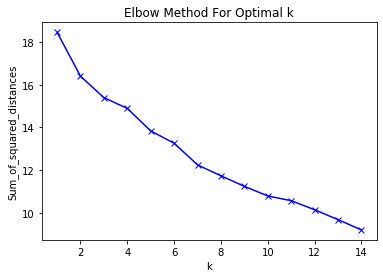

In [241]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

##### Running the cluster analysis using the best k value according to the elbow method

In [215]:
# set number of clusters
kclusters = 7

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)
Toronto_grouped['Cluster Labels'] = kmeans.labels_

Toronto_grouped.rename(columns={"Neighborhood":"Neighbourhood"},inplace=True)

Toronto_merged=pd.merge (Toronto_data,Toronto_grouped,how='inner',on='Neighbourhood')

### Map points according to their cluster number 

In [216]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], 
                                  Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Most common venues for cluster 0

In [224]:
neighborhoods_venues_sorted.rename(columns={"Neighborhood":"Neighbourhood"},inplace=True)
Clusters=Toronto_merged[['Neighbourhood','Cluster Labels']]
Clusters=pd.merge (neighborhoods_venues_sorted,Clusters,how='inner',on='Neighbourhood')
Clusters[Clusters['Cluster Labels']==0]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
52,"Highland Creek, Rouge Hill, Port Union",History Museum,Bar,Home Service,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store,0


### Most common venues for cluster 1

In [225]:
Clusters[Clusters['Cluster Labels']==1]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Café,Thai Restaurant,Steakhouse,Bar,Pizza Place,Seafood Restaurant,Lounge,Hotel,1
1,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,1
5,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Bank,Pet Store,Sandwich Place,Supermarket,Middle Eastern Restaurant,Shopping Mall,Restaurant,Deli / Bodega,Diner,1
6,Bayview Village,Japanese Restaurant,Chinese Restaurant,Café,Bank,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store,1
7,"Bedford Park, Lawrence Manor East",Restaurant,Coffee Shop,Sandwich Place,Italian Restaurant,Indian Restaurant,Butcher,Fast Food Restaurant,Sushi Restaurant,Café,Pub,1
8,Berczy Park,Coffee Shop,Seafood Restaurant,Restaurant,Beer Bar,Bakery,Farmers Market,Cocktail Bar,Cheese Shop,Café,Park,1
9,"Birch Cliff, Cliffside West",College Stadium,Skating Rink,Café,General Entertainment,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,1
10,"Bloordale Gardens, Eringate, Markland Wood, Ol...",Pizza Place,Convenience Store,Beer Store,Shopping Plaza,Liquor Store,Café,Cosmetics Shop,Pet Store,Coffee Shop,Concert Hall,1
11,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Nightclub,Coffee Shop,Café,Climbing Gym,Burrito Place,Japanese Restaurant,Italian Restaurant,Stadium,Intersection,1
12,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Butcher,Garden,Recording Studio,Fast Food Restaurant,Auto Workshop,Farmers Market,Burrito Place,Brewery,Spa,1


### Most common venues for cluster 2

In [226]:
#Most common venues for cluster 2
Clusters[Clusters['Cluster Labels']==2]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
74,Roselawn,Garden,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega,2


### Most common venues for cluster 3

In [227]:
Clusters[Clusters['Cluster Labels']==3]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,3
13,"CFB Toronto, Downsview East",Airport,Park,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,3
16,Caledonia-Fairbanks,Park,Women's Store,Market,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore,3
38,"Downsview, North Park, Upwood Park",Park,Bakery,Construction & Landscaping,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,3
40,East Toronto,Convenience Store,Coffee Shop,Park,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,3
62,Lawrence Park,Bus Line,Park,Swim School,Women's Store,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,3
66,"Moore Park, Summerhill East",Tennis Court,Park,Playground,Restaurant,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,3
71,Parkwoods,Park,Food & Drink Shop,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,3
73,Rosedale,Park,Playground,Trail,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,3
88,"The Kingsway, Montgomery Road, Old Mill North",River,Park,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,3


### Most common venues for cluster 4

In [228]:
Clusters[Clusters['Cluster Labels']==4]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
79,"Silver Hills, York Mills",Cafeteria,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Department Store,4


### Most common venues for cluster 5

In [229]:
Clusters[Clusters['Cluster Labels']==5]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Fried Chicken Joint,Sandwich Place,Liquor Store,Beer Store,Fast Food Restaurant,Pharmacy,Gay Bar,Curling Ice,5
4,"Alderwood, Long Branch",Pizza Place,Skating Rink,Coffee Shop,Pharmacy,Pool,Pub,Sandwich Place,Gym,Airport Service,Ethiopian Restaurant,5
24,"Clarks Corners, Sullivan, Tam O'Shanter",Pizza Place,Pharmacy,Fast Food Restaurant,Rental Car Location,Intersection,Thai Restaurant,Fried Chicken Joint,Italian Restaurant,Convenience Store,Chinese Restaurant,5
46,Glencairn,Pizza Place,Park,Pub,Japanese Restaurant,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Deli / Bodega,5
56,Humber Summit,Empanada Restaurant,Pizza Place,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop,5
58,"Kingsview Village, Martin Grove Gardens, Richv...",Pizza Place,Mobile Phone Shop,Bus Line,Sandwich Place,Distribution Center,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Department Store,5
60,L'Amoreaux West,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Thrift / Vintage Store,Grocery Store,Pharmacy,Breakfast Spot,Coffee Shop,Bank,Sandwich Place,5
87,"The Junction North, Runnymede",Pizza Place,Convenience Store,Grocery Store,Bus Line,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,5
91,Westmount,Pizza Place,Discount Store,Sandwich Place,Intersection,Chinese Restaurant,Coffee Shop,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,5
94,Willowdale West,Pizza Place,Bank,Discount Store,Pharmacy,Coffee Shop,Butcher,Grocery Store,Airport Lounge,Falafel Restaurant,Event Space,5


### Most common venues for cluster 6

In [230]:
#Most common venues for cluster 6
Clusters[Clusters['Cluster Labels']==6]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
75,"Rouge, Malvern",Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,6
